In [1]:
# pip install openinference-instrumentation-dspy dspy
# pip install openinference-instrumentation-litellm arize-phoenix litellm

In [2]:
import pandas as pd
import gc
import torch
from datasets import Dataset
from tqdm.notebook import tqdm
import random
from dspy.datasets import DataLoader
random.seed(42)
dl = DataLoader()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from dspy.teleprompt import BootstrapFewShot
import phoenix as px
phoenix_session = px.launch_app()
print(phoenix_session.url)
from openinference.instrumentation.dspy import DSPyInstrumentor
from openinference.instrumentation.litellm import LiteLLMInstrumentor
from phoenix.otel import register

tracer_provider = register(project_name='LLMs')

file_path = 'cleaned_concatenated.csv'
df = pd.read_csv(file_path)
df.head()

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix
http://localhost:6006/
🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: LLMs
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



,index,Question,Recommendation
0,0,How does one determine the optimal DMARC polic...,Determining the optimal DMARC policy for a dom...
1,1,How does the err tag in a DMARC record handle ...,In the context of email authentication protoco...
2,2,How does the presence or absence of the l tag ...,The l tag in a DMARC record plays a crucial ro...
3,3,How does the rua tag in a DMARC record enable ...,The rua tag in a DMARC record plays a crucial ...
4,4,"Can the mode tag in a DMARC record be omitted,...","In the context of DKIM, DMARC, and SPF, the mo..."


In [3]:
import langwatch
# sk-lw-4rp0bjgnXJZGGKZ4gjCKVZpHxUfiY4U0bel4PLSlDeJisYpy
# langwatch.login()
langwatch.api_key = 'sk-lw-4rp0bjgnXJZGGKZ4gjCKVZpHxUfiY4U0bel4PLSlDeJisYpy'

In [4]:
# https://dspy.ai/learn/optimization/overview/    # 20% train, 80% test
trainset_df, devset_df = train_test_split(df, test_size=0.1, random_state=42)  

trainset_df = Dataset.from_pandas(trainset_df)
devset_df = Dataset.from_pandas(devset_df)

In [5]:
trainset_df.shape

(145, 4)

In [6]:
devset_df.shape

(17, 4)

In [7]:
import dspy
# llm_model = dspy.LM('ollama_chat/llama3.2', api_base='http://localhost:11434', api_key='')
# dspy.configure(lm=llm_model)

In [8]:
trainset, devset=[],[]

for i,ex in enumerate(trainset_df):
    example = dspy.Example(question = ex["Question"], answer=ex["Recommendation"]).with_inputs('question')
    trainset.append(example)

for i,ex in enumerate(devset_df):
    example = dspy.Example(question = ex["Question"], answer=ex["Recommendation"]).with_inputs('question')
    devset.append(example)

In [9]:
# temp
# trainset = dl.sample(trainset, n=30)

In [10]:
trainset = trainset[:10]
devset = devset[:5]

In [11]:
LLMinstruction = """Evaluate the provided answer using the following instructions:
    
    **Instructions:**
    **Scoring**: Assign:
        - **1** if all criteria are met
        - **0** if any criterion is unmet
        
    **Response Format:**
        - **Score**: Either 1 or 0.
        
    **Evaluation Criteria:**
        - **Accuracy**: Are the facts correct and aligned with email security standards (e.g., DMARC, SPF, DKIM)?
        - **Clarity**: Is the response concise, well-structured, and easy to understand?
        - **Completeness**: Does it fully address the question and cover all relevant aspects?
        - **Relevance**: Is the answer tailored to the specific question and email security domain?
        - **Actionability**: Does it provide clear, practical steps or solutions?
        - **Technical Depth**: Are technical terms accurate and appropriate tools mentioned?
        - **Deliverability Impact**: Does it balance security and email deliverability?
        - **Efficiency**: Is the explanation concise without redundancy?
        - **Insightfulness**: Does it help identify issues or suggest proactive improvements?
        - **Usability**: Is it adaptable to both technical and non-technical users with real-world examples?"""

class llmJudge(dspy.Signature):
    """You are an expert evaluator responsible for assessing whether a given answer meets the specified evaluation criteria."""

    instruction = dspy.InputField(desc="Instructions to Evaluate the provided answer")
    question = dspy.InputField(desc="Question to be answered")
    answer = dspy.InputField(desc="Answer for the question")
    factually_correct = dspy.OutputField(desc="Assign: 1 if all criteria are met, 0 if any criterion is unmet")

judge = dspy.ChainOfThought(llmJudge)

def llm_metric(example, pred):
    factual = judge(instruction=LLMinstruction, question=example.question, answer=pred.answer)
    return factual.factually_correct

In [12]:
def llmscore(outputs):
    return sum([1 if '1' in llm_metric(output[0],output[1]) else 0 for output in tqdm(outputs)])/len(outputs)

In [13]:
from semscore import EmbeddingModelWrapper
from statistics import mean
em = EmbeddingModelWrapper()
def SemScore(example, pred, trace=None):
    similarities = em.get_similarities(
        em.get_embeddings([example.answer]),
        em.get_embeddings([pred.answer]),
    )
    
    return mean(similarities)

2025-01-16 20:14:40.311414: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 20:14:40.326328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737038680.345944  212405 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737038680.351782  212405 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 20:14:40.372168: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [14]:
from dspy.evaluate import Evaluate
evaluate_program = Evaluate(devset=devset, metric= SemScore, 
                            num_threads=1, 
                            display_progress=True, 
                            display_table=5,return_outputs=True)

In [15]:
def save_table(output,name):
    temp_df = [{'Question':out[0].question,'True_Answer':out[0].answer,'Pred_Answer':out[1].answer,'Score':out[2]} for out in output]
    temp_df = pd.DataFrame(temp_df)
    temp_df.to_csv(f"{name}.csv",index=False)

<div style="background-color: yellow; padding: 10px; border-radius: 5px; font-size: 18px; font-weight: bold;">
    Using **Predict** Module
</div>

# Zero Shot

In [16]:
class ZS_GenerateAnswer(dspy.Signature):
    """
    You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.
    """
    question = dspy.InputField(desc="User's Question about email security") 
    answer = dspy.OutputField(desc="The expert's ideal Recommendation to the Question")

class ZS_PredictModel(dspy.Module):
    def __init__(self):
        self.predict = dspy.Predict(ZS_GenerateAnswer)
    def forward(self, question):
        return self.predict(question=question)

# Few Shot

In [17]:
class FewShotGenerateAnswer(dspy.Signature):
    """
    You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.
    """
    example = dspy.InputField(desc="Few Examples") 
    question = dspy.InputField(desc="User's Question about email security") 
    answer = dspy.OutputField(desc="The expert's ideal Recommendation to the Question")

class FewShot_PredictModel(dspy.Module):
    def __init__(self, examples):
        self.predict = dspy.Predict(FewShotGenerateAnswer)
        self.fewExamples = examples  # Few-shot examples

    def forward(self, question):
        return self.predict(example=self.fewExamples,question=question)

In [18]:
import random
from dspy.datasets import DataLoader
random.seed(42)
dl = DataLoader()
# few_shot_examples = random.sample(trainset, 20)

# few_shot_examples = dl.sample(trainset, n=1) # `dataset` is a List of dspy.Example

few_shot_examples = trainset[0:1]

context = ""
for example in few_shot_examples:
    context += f"Q: {example['question']}\nA: {example['answer']}\n\n"
few_shot_examples = context.strip()

<div style="background-color: yellow; padding: 10px; border-radius: 5px; font-size: 18px; font-weight: bold;">
    Using **ChainOfThought** Module
</div>

# Zero Shot

In [19]:
class ZS_GenerateAnswer(dspy.Signature):
    """
    You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.
    """
    question = dspy.InputField(desc="User's Question about email security") 
    answer = dspy.OutputField(desc="The expert's ideal Recommendation to the Question")

class ZS_CotModel(dspy.Module):
    def __init__(self):
        self.predict = dspy.ChainOfThought(ZS_GenerateAnswer)
    def forward(self, question):
        return self.predict(question=question)

# Few Shot

In [20]:
class FewShotGenerateAnswer(dspy.Signature):
    """
    You are an expert in email security. Your goal is to give Recommendation to the user based on their Question.
    """
    question = dspy.InputField(desc="User's Question about email security") 
    answer = dspy.OutputField(desc="The expert's ideal Recommendation to the Question")

class FewShot_CotModel(dspy.Module):
    def __init__(self):
        self.predict = dspy.ChainOfThought(FewShotGenerateAnswer)

    def forward(self, question):
        return self.predict(question=question)

In [21]:
results_semscore = []
results_llmjudge = []

<div style="background-color: orange; padding: 10px; border-radius: 5px; font-size: 18px; font-weight: bold;">
    llama3.2
</div>

In [22]:
model = dspy.LM('ollama_chat/llama3.2', api_base='http://localhost:11434', api_key='')
judge_model = model.copy()
dspy.configure(lm=model)

with dspy.context(lm = model):

    optimizer = BootstrapFewShot(metric=SemScore,max_labeled_demos=2,
                             max_bootstrapped_demos=2,
                             teacher_settings=dict(lm=model),
                             max_rounds=10)

    langwatch.dspy.init(experiment="LLM_16Jan", optimizer=optimizer,run_id='run-1')
    compiled_cot_fewshot = optimizer.compile(FewShot_CotModel(), trainset=trainset)

    print('ModelName:******',dspy.settings.lm.model,'********')

    DSPyInstrumentor().instrument(tracer_provider=tracer_provider,skip_dep_check=True)
    LiteLLMInstrumentor().instrument(tracer_provider=tracer_provider,skip_dep_check=True)

    eval_zeroshot_predict,outputs1 = evaluate_program(ZS_PredictModel())
    eval_fewshot_predict,outputs2 = evaluate_program(FewShot_PredictModel(few_shot_examples))

    eval_zeroshot_cot,outputs3 = evaluate_program(ZS_CotModel())
    eval_fewshot_cot,outputs4 = evaluate_program(compiled_cot_fewshot)

    results_semscore.append({
        'Model': model.model,
        'Zero Shot -Direct': eval_zeroshot_predict,
        'Few Shot -Direct': eval_fewshot_predict,
        'Zero Shot -COT': eval_zeroshot_cot,
        'Few Shot -COT': eval_fewshot_cot
    })

with dspy.context(lm = judge_model):
    results_llmjudge.append({
        'Model': model.model,
        'Zero Shot -Direct': llmscore(outputs1),
        'Few Shot -Direct': llmscore(outputs2),
        'Zero Shot -COT': llmscore(outputs3),
        'Few Shot -COT': llmscore(outputs4)
        })


[LangWatch] Experiment initialized, run_id: run-1
[LangWatch] Open https://app.langwatch.ai/nit-SKJiRK/experiments/llm-16jan?runIds=run-1 to track your DSPy training session live



 20%|████████▊                                   | 2/10 [00:00<00:01,  5.19it/s]


Bootstrapped 2 full traces after 2 examples for up to 10 rounds, amounting to 2 attempts.
ModelName:****** ollama_chat/llama3.2 ********
Average Metric: 4.28 / 5 (85.7%): 100%|███████████| 5/5 [00:00<00:00, 11.35it/s]

2025/01/16 20:14:45 INFO dspy.evaluate.evaluate: Average Metric: 4.283949315547943 / 5 (85.7%)


,question,example_answer,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,Our organization employs several mechanisms to prevent unauthorize...,✔️ [0.780]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Our organization follows a structured approach to handle complex S...,✔️ [0.877]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,When defining and configuring SPF (Sender Policy Framework) record...,✔️ [0.903]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,To ensure that your SPF records are properly propagated to all DNS...,✔️ [0.872]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,Our organization employs a multi-faceted approach to manage SPF re...,✔️ [0.852]


Average Metric: 4.28 / 5 (85.7%): 100%|███████████| 5/5 [00:00<00:00, 19.90it/s]

2025/01/16 20:14:45 INFO dspy.evaluate.evaluate: Average Metric: 4.283949315547943 / 5 (85.7%)


,question,example_answer,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,Our organization employs several mechanisms to prevent unauthorize...,✔️ [0.780]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Our organization follows a structured approach to handle complex S...,✔️ [0.877]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,When defining and configuring SPF (Sender Policy Framework) record...,✔️ [0.903]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,To ensure that your SPF records are properly propagated to all DNS...,✔️ [0.872]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,Our organization employs a multi-faceted approach to manage SPF re...,✔️ [0.852]


Average Metric: 4.07 / 5 (81.4%): 100%|███████████| 5/5 [00:00<00:00, 11.99it/s]

2025/01/16 20:14:46 INFO dspy.evaluate.evaluate: Average Metric: 4.0686792731285095 / 5 (81.4%)


,question,example_answer,reasoning,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,Our organization employs several mechanisms to prevent unauthorize...,"To implement these mechanisms effectively, we recommend the follow...",✔️ [0.710]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Our organization's strategy for handling complex SPF record wildca...,To ensure proper management of complex SPF record wildcard and mac...,✔️ [0.878]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,When defining and configuring SPF (Sender Policy Framework) record...,To define and configure SPF record scopes for your organization's ...,✔️ [0.757]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,To ensure that SPF records are properly propagated to all DNS serv...,"To address the issue of SPF record inconsistencies or conflicts, o...",✔️ [0.890]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,Our organization follows a structured approach to managing SPF rec...,To manage SPF record wildcards and macros across multiple domains ...,✔️ [0.833]


Average Metric: 4.13 / 5 (82.6%): 100%|███████████| 5/5 [00:00<00:00,  9.79it/s]

2025/01/16 20:14:46 INFO dspy.evaluate.evaluate: Average Metric: 4.128271520137787 / 5 (82.6%)


,question,example_answer,reasoning,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,To prevent unauthorized senders from using its domains in the MAIL...,"To implement and maintain these mechanisms, an organization can fo...",✔️ [0.723]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Handling complex SPF record wildcard and macro configurations requ...,To ensure complex SPF record wildcard and macro configurations are...,✔️ [0.850]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,To define and configure SPF record scopes for an organization's do...,"To configure SPF record scopes, follow these steps: 1. **Identify ...",✔️ [0.829]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,Ensuring that SPF records are properly propagated to all DNS serve...,To ensure that SPF records are properly propagated to all DNS serv...,✔️ [0.822]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,Managing SPF record wildcards and macros across multiple domains a...,To manage SPF record wildcards and macros across multiple domains ...,✔️ [0.904]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<div style="background-color: orange; padding: 10px; border-radius: 5px; font-size: 18px; font-weight: bold;">
    qwen2
</div>

In [23]:
model = dspy.LM('ollama_chat/qwen2:1.5b', api_base='http://localhost:11434', api_key='')
dspy.configure(lm=model)

with dspy.context(lm = model):

    optimizer = BootstrapFewShot(metric=SemScore,max_labeled_demos=2,
                             max_bootstrapped_demos=2,
                             teacher_settings=dict(lm=model),
                             max_rounds=10)
    
    langwatch.dspy.init(experiment="LLM_16Jan", optimizer=optimizer,run_id='run-1')
    compiled_cot_fewshot = optimizer.compile(FewShot_CotModel(), trainset=trainset)

    print('ModelName:******',dspy.settings.lm.model,'********')
    DSPyInstrumentor().instrument(tracer_provider=tracer_provider,skip_dep_check=True)
    LiteLLMInstrumentor().instrument(tracer_provider=tracer_provider,skip_dep_check=True)

    eval_zeroshot_predict,outputs1 = evaluate_program(ZS_PredictModel())
    eval_fewshot_predict,outputs2 = evaluate_program(FewShot_PredictModel(few_shot_examples))

    eval_zeroshot_cot,outputs3 = evaluate_program(ZS_CotModel())
    eval_fewshot_cot,outputs4 = evaluate_program(compiled_cot_fewshot)

    results_semscore.append({
        'Model': model.model,
        'Zero Shot -Direct': eval_zeroshot_predict,
        'Few Shot -Direct': eval_fewshot_predict,
        'Zero Shot -COT': eval_zeroshot_cot,
        'Few Shot -COT': eval_fewshot_cot
    })

with dspy.context(lm = judge_model):
    results_llmjudge.append({
        'Model': model.model,
        'Zero Shot -Direct': llmscore(outputs1),
        'Few Shot -Direct': llmscore(outputs2),
        'Zero Shot -COT': llmscore(outputs3),
        'Few Shot -COT': llmscore(outputs4)
        })


[LangWatch] Experiment initialized, run_id: run-1
[LangWatch] Open https://app.langwatch.ai/nit-SKJiRK/experiments/llm-16jan?runIds=run-1 to track your DSPy training session live



 20%|████████▊                                   | 2/10 [00:00<00:00, 11.97it/s]

Bootstrapped 2 full traces after 2 examples for up to 10 rounds, amounting to 2 attempts.



Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


ModelName:****** ollama_chat/qwen2:1.5b ********
Average Metric: 4.17 / 5 (83.5%): 100%|███████████| 5/5 [00:00<00:00, 15.24it/s]

2025/01/16 20:14:49 INFO dspy.evaluate.evaluate: Average Metric: 4.17343944311142 / 5 (83.5%)


,question,example_answer,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,To prevent unauthorized senders from using your domain in the MAIL...,✔️ [0.724]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Managing complex SPF record wildcard and macro configurations requ...,✔️ [0.878]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,To define and configure SPF (Sender Policy Framework) record scope...,✔️ [0.869]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,"To ensure proper propagation of SPF records, organizations should ...",✔️ [0.878]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,"To manage SPF records, organizations can use a combination of wild...",✔️ [0.825]


Average Metric: 4.17 / 5 (83.5%): 100%|███████████| 5/5 [00:00<00:00, 15.59it/s]

2025/01/16 20:14:50 INFO dspy.evaluate.evaluate: Average Metric: 4.17343944311142 / 5 (83.5%)


,question,example_answer,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,To prevent unauthorized senders from using your domain in the MAIL...,✔️ [0.724]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Managing complex SPF record wildcard and macro configurations requ...,✔️ [0.878]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,To define and configure SPF (Sender Policy Framework) record scope...,✔️ [0.869]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,"To ensure proper propagation of SPF records, organizations should ...",✔️ [0.878]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,"To manage SPF records, organizations can use a combination of wild...",✔️ [0.825]


Average Metric: 3.44 / 5 (68.8%): 100%|███████████| 5/5 [00:00<00:00,  8.85it/s]

2025/01/16 20:14:50 INFO dspy.evaluate.evaluate: Average Metric: 3.437988519668579 / 5 (68.8%)


,question,example_answer,reasoning,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,To prevent unauthorized senders from using your organization's dom...,To prevent unauthorized senders from using your organization's dom...,✔️ [0.628]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Handling complex SPF record wildcard and macro configurations requ...,- Identify the complexity of the configuration - Review existing p...,✔️ [0.285]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,To define and configure SPF (Sender Policy Framework) record scope...,To define and configure SPF record scopes for your organization's ...,✔️ [0.780]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,"To ensure proper propagation of SPF records, organizations should ...","To ensure proper propagation of SPF records, organizations should ...",✔️ [0.887]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,"Managing SPF records can be complex, especially when dealing with ...",To handle the management of SPF record wildcards and macros across...,✔️ [0.857]


Average Metric: 4.46 / 5 (89.2%): 100%|███████████| 5/5 [00:00<00:00, 12.26it/s]

2025/01/16 20:14:51 INFO dspy.evaluate.evaluate: Average Metric: 4.459033012390137 / 5 (89.2%)


,question,example_answer,reasoning,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,Not supplied for this particular example.,Preventing Unauthorized Senders from Using Domains in MAIL FROM Co...,✔️ [0.838]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Not supplied for this particular example.,Handling Complex SPF Record Wildcard and Macro Configurations ----...,✔️ [0.916]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,Not supplied for this particular example.,Specific Guidelines for Defining and Configuring SPF Record Scopes...,✔️ [0.894]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,Not supplied for this particular example.,Propagating SPF Records to All DNS Servers and Mail Servers ------...,✔️ [0.900]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,Not supplied for this particular example.,Managing SPF Record Wildcards and Macros Across Multiple Domains a...,✔️ [0.911]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<div style="background-color: orange; padding: 10px; border-radius: 5px; font-size: 18px; font-weight: bold;">
    Gemma2
</div>

In [24]:
model = dspy.LM('ollama_chat/gemma2:2b', api_base='http://localhost:11434', api_key='')
dspy.configure(lm=model)

with dspy.context(lm = model):

    optimizer = BootstrapFewShot(metric=SemScore,max_labeled_demos=2,
                             max_bootstrapped_demos=2,
                             teacher_settings=dict(lm=model),
                             max_rounds=10)
    
    langwatch.dspy.init(experiment="LLM_16Jan", optimizer=optimizer,run_id='run-1')
    compiled_cot_fewshot = optimizer.compile(FewShot_CotModel(), trainset=trainset)

    print('ModelName:******',dspy.settings.lm.model,'********')
    DSPyInstrumentor().instrument(tracer_provider=tracer_provider,skip_dep_check=True)
    LiteLLMInstrumentor().instrument(tracer_provider=tracer_provider,skip_dep_check=True)

    eval_zeroshot_predict,outputs1 = evaluate_program(ZS_PredictModel())
    eval_fewshot_predict,outputs2 = evaluate_program(FewShot_PredictModel(few_shot_examples))

    eval_zeroshot_cot,outputs3 = evaluate_program(ZS_CotModel())
    eval_fewshot_cot,outputs4 = evaluate_program(compiled_cot_fewshot)

    results_semscore.append({
        'Model': model.model,
        'Zero Shot -Direct': eval_zeroshot_predict,
        'Few Shot -Direct': eval_fewshot_predict,
        'Zero Shot -COT': eval_zeroshot_cot,
        'Few Shot -COT': eval_fewshot_cot
    })

with dspy.context(lm = judge_model):
    results_llmjudge.append({
        'Model': model.model,
        'Zero Shot -Direct': llmscore(outputs1),
        'Few Shot -Direct': llmscore(outputs2),
        'Zero Shot -COT': llmscore(outputs3),
        'Few Shot -COT': llmscore(outputs4)
        })


[LangWatch] Experiment initialized, run_id: run-1
[LangWatch] Open https://app.langwatch.ai/nit-SKJiRK/experiments/llm-16jan?runIds=run-1 to track your DSPy training session live



 20%|████████▊                                   | 2/10 [00:15<01:02,  7.79s/it]


Bootstrapped 2 full traces after 2 examples for up to 10 rounds, amounting to 2 attempts.


Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


ModelName:****** ollama_chat/gemma2:2b ********
Average Metric: 4.22 / 5 (84.4%): 100%|███████████| 5/5 [00:19<00:00,  3.94s/it]

2025/01/16 20:15:29 INFO dspy.evaluate.evaluate: Average Metric: 4.221176505088806 / 5 (84.4%)


,question,example_answer,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,Our organization employs a multi-layered approach to prevent unaut...,✔️ [0.746]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Our organization employs a multi-layered approach to managing comp...,✔️ [0.867]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,Defining and configuring SPF records for our organization's domain...,✔️ [0.861]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,Ensuring proper propagation of SPF records across your organizatio...,✔️ [0.886]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,Managing SPF records with wildcards and macros across multiple dom...,✔️ [0.862]


Average Metric: 4.22 / 5 (84.4%): 100%|███████████| 5/5 [00:00<00:00, 18.65it/s]

2025/01/16 20:15:29 INFO dspy.evaluate.evaluate: Average Metric: 4.221176505088806 / 5 (84.4%)


,question,example_answer,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,Our organization employs a multi-layered approach to prevent unaut...,✔️ [0.746]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Our organization employs a multi-layered approach to managing comp...,✔️ [0.867]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,Defining and configuring SPF records for our organization's domain...,✔️ [0.861]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,Ensuring proper propagation of SPF records across your organizatio...,✔️ [0.886]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,Managing SPF records with wildcards and macros across multiple dom...,✔️ [0.862]


Average Metric: 4.08 / 5 (81.7%): 100%|███████████| 5/5 [00:29<00:00,  5.84s/it]

2025/01/16 20:15:59 INFO dspy.evaluate.evaluate: Average Metric: 4.084993660449982 / 5 (81.7%)


,question,example_answer,reasoning,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,Email security is a multi-layered approach. Preventing unauthorize...,To prevent unauthorized senders from using your domains in the MAI...,✔️ [0.727]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Handling complex SPF record wildcard and macro configurations requ...,Here's a breakdown of how to approach SPF record management for co...,✔️ [0.807]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,SPF (Sender Policy Framework) is a crucial part of email authentic...,Here's a breakdown of how we approach SPF record scopes: 1. **Defi...,✔️ [0.854]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,Ensuring proper propagation of SPF records across all DNS servers ...,"To ensure proper propagation and prevent inconsistencies, follow t...",✔️ [0.855]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,Managing SPF record wildcards and macros across multiple domains a...,To effectively manage SPF record wildcards and macros across multi...,✔️ [0.842]


Average Metric: 4.46 / 5 (89.2%): 100%|███████████| 5/5 [00:32<00:00,  6.49s/it]

2025/01/16 20:16:31 INFO dspy.evaluate.evaluate: Average Metric: 4.45858496427536 / 5 (89.2%)


,question,example_answer,reasoning,pred_answer,SemScore
0,What mechanisms does your organization use to prevent unauthorized...,Introduction to SPF Records and Mechanisms =======================...,Preventing unauthorized senders from using an organization's domai...,Mechanisms for Preventing Unauthorized Senders ===================...,✔️ [0.848]
1,What is your organization's strategy for handling complex SPF reco...,Introduction to SPF Record Wildcard and Macro Configurations =====...,Complex SPF record configurations using wildcards and macros can p...,Handling Complex SPF Record Configurations: A Strategic Approach =...,✔️ [0.931]
2,What specific guidelines do you follow to define and configure SPF...,Introduction to SPF Record Scopes ================================...,Defining and configuring SPF record scopes is crucial to ensure ac...,Guidelines for Defining and Configuring SPF Record Scopes ========...,✔️ [0.889]
3,How do you ensure that your SPF records are properly propagated to...,Ensuring Proper Propagation and Consistency of SPF Records: A Comp...,Ensuring consistent and accurate SPF records across all DNS server...,Propagating SPF Records: Ensuring Consistency and Preventing Confl...,✔️ [0.899]
4,How does your organization handle the management of SPF record wil...,Introduction to SPF Record Wildcards and Macros Management =======...,Managing SPF record wildcards and macros across multiple domains a...,Managing SPF Record Wildcards and Macros Across Multiple Domains a...,✔️ [0.891]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<div style="background-color: pink; padding: 10px; border-radius: 5px; font-size: 18px; font-weight: bold;">
    Graphs
</div>

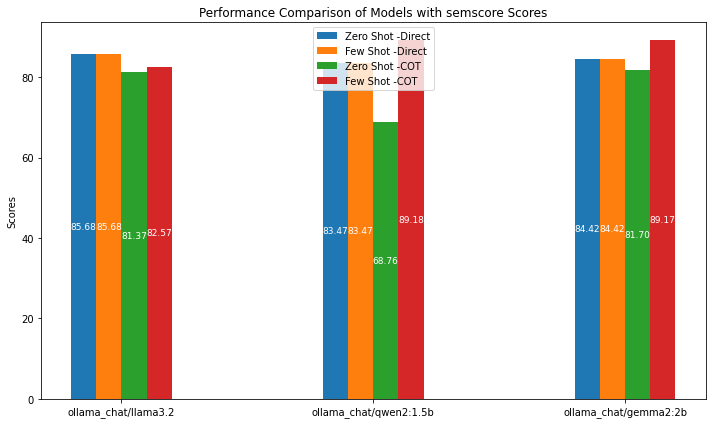

In [26]:
import matplotlib.pyplot as plt
df = pd.DataFrame(results_semscore)

# Plot with scores centered on bars
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(df['Model']))

# Bar widths and positions
width = 0.1

# Plot each metric
bars1 = ax.bar(x, df['Zero Shot -Direct'], width=width, label='Zero Shot -Direct', align='center')
bars2 = ax.bar([i + width for i in x], df['Few Shot -Direct'], width=width, label='Few Shot -Direct', align='center')
bars3 = ax.bar([i + 2 * width for i in x], df['Zero Shot -COT'], width=width, label='Zero Shot -COT', align='center')
bars4 = ax.bar([i + 3 * width for i in x], df['Few Shot -COT'], width=width, label='Few Shot -COT', align='center')

# Add individual scores at the center of bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height:.2f}',
                ha='center', va='center', fontsize=9, color='white')

# Customize plot
ax.set_xticks([i + 1.5 * width for i in x])
ax.set_xticklabels(df['Model'])
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Models with semscore Scores')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()



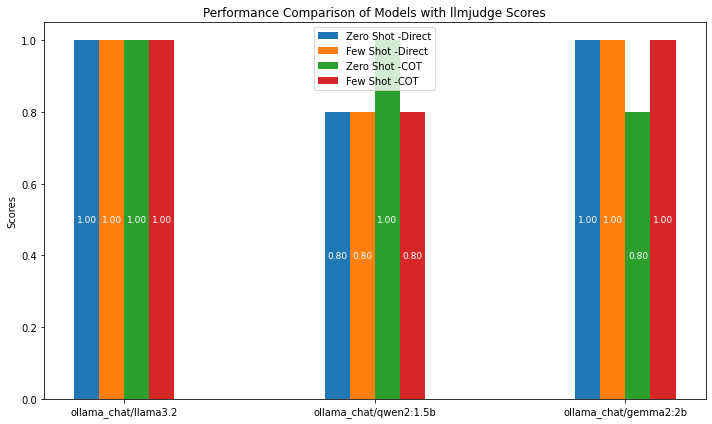

In [27]:
df = pd.DataFrame(results_llmjudge)

# Plot with scores centered on bars
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(df['Model']))

# Bar widths and positions
width = 0.1

# Plot each metric
bars1 = ax.bar(x, df['Zero Shot -Direct'], width=width, label='Zero Shot -Direct', align='center')
bars2 = ax.bar([i + width for i in x], df['Few Shot -Direct'], width=width, label='Few Shot -Direct', align='center')
bars3 = ax.bar([i + 2 * width for i in x], df['Zero Shot -COT'], width=width, label='Zero Shot -COT', align='center')
bars4 = ax.bar([i + 3 * width for i in x], df['Few Shot -COT'], width=width, label='Few Shot -COT', align='center')

# Add individual scores at the center of bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height:.2f}',
                ha='center', va='center', fontsize=9, color='white')

# Customize plot
ax.set_xticks([i + 1.5 * width for i in x])
ax.set_xticklabels(df['Model'])
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Models with llmjudge Scores')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

